# 개와 고양이 이미지 분류하기

이전의 예제에서 다루었던 MNIST, Fashion MNIST 데이터셋은 이미지 패턴이 비교적 단순하며 흑백의 색상을 가지고, 이미지가 모두 같은 크기를 가지기 때문에 상대적으로 쉬운 문제로 알려져 있습니다.

하지만 현실의 이미지 분류 문제는 이와 달리 더 복잡한 패턴을 가지거나 다양한 색상을 가지고, 또한 이미지의 크기가 달라질 수 있습니다.

이번 페이지에서는 잘 알려진 이미지 분류 문제인 Kaggle Dogs Vs Cats 데이터셋을 살펴보고, Neural Network를 구성하고 훈련시켜서, 정확도를 확인하는 과정에 대해 순서대로 소개합니다.


# Kaggle Dogs Vs Cats 데이터셋 준비하기

### 다운로드하기

In [1]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2022-04-08 08:53:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   202MB/s    in 0.3s    

2022-04-08 08:53:02 (202 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



우선 Colab 코드셀에 위의 명령어를 입력해서 데이터셋을 다운로드합니다.

아래 그림과 같이 페이지 왼쪽의 목차 탭을 열어서 tmp 폴더에

cats_and_dogs_filtered.zip 파일이 다운로드되어 있는지 확인합니다.

cats_and_dogs_filtered 데이터셋은 25,000개의 이미지를 포함하는 원본 Dogs Vs. Cats 데이터셋에서 약 3,000개의 이미지를 추출한 간소화된 버전의 데이터셋입니다.

### 압축풀기

In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r') # zip파일 읽기 모드로 열기

zip_ref.extractall('/tmp') # 압출풀기

zip_ref.close()

os 라이브러리를 통해 파일시스템에 접근할 수 있습니다.

zipfile 라이브러리의 ZipFile 클래스로 Zip파일을 연 후에

extractall()메서드를 이용해서 tmp폴더에 압축을 풉니다.

### 경로 지정하기

In [3]:
# 기본 경로
base_dir = '/tmp/cats_and_dogs_filtered'

# train/validation 폴더 경로
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 고양이/개 이미지 경로
train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
print(train_cats_dir)
print(train_dogs_dir)

# 테스트에 사용되는 고양이/개 이미지 경로
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')
print(validation_cats_dir)
print(validation_dogs_dir)

/tmp/cats_and_dogs_filtered/train/cats
/tmp/cats_and_dogs_filtered/train/dogs
/tmp/cats_and_dogs_filtered/validation/cats
/tmp/cats_and_dogs_filtered/validation/dogs


기본 경로와 훈련에 사용되는 고양이/개 이미지의 경로를 각각 지정해줍니다.

### Kaggle Dogs Vs Cats 데이터셋 살펴보기

### 파일 이름과 개수

In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

validation_cat_fnames = os.listdir(validation_cats_dir)
validation_dog_fnames = os.listdir(validation_dogs_dir)

print(validation_cat_fnames[:5])
print(validation_dog_fnames[:5])

['cat.48.jpg', 'cat.3.jpg', 'cat.307.jpg', 'cat.534.jpg', 'cat.538.jpg']
['dog.56.jpg', 'dog.675.jpg', 'dog.465.jpg', 'dog.218.jpg', 'dog.490.jpg']
['cat.2464.jpg', 'cat.2294.jpg', 'cat.2172.jpg', 'cat.2228.jpg', 'cat.2269.jpg']
['dog.2215.jpg', 'dog.2141.jpg', 'dog.2109.jpg', 'dog.2326.jpg', 'dog.2497.jpg']


os.listdir() 메서드는 경로 내에 있는 파일의 이름을 리스트의 형태로 반환합니다.

각각 5개 씩 출력했습니다.

In [5]:
print('Total training cat images :', len(os.listdir(train_cats_dir)))
print('Total training dog images :', len(os.listdir(train_dogs_dir)))

print('Total validation cat images :', len(os.listdir(validation_cats_dir)))
print('Total validation dog images :', len(os.listdir(validation_dogs_dir)))

Total training cat images : 1000
Total training dog images : 1000
Total validation cat images : 500
Total validation dog images : 500


각 경로에 있는 파일명 리스트의 길이를 통해 파일의 개수를 확인합니다.

### 이미지 확인하기

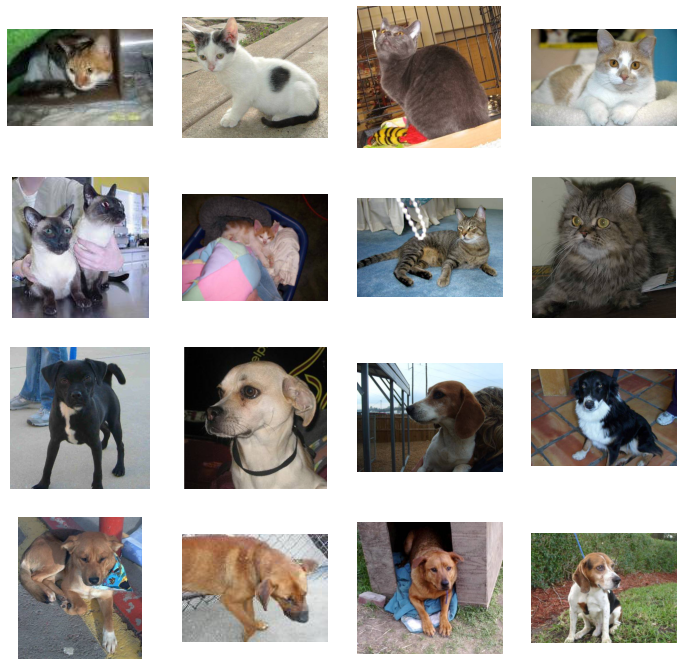

In [6]:
% matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### 모델 구성하기

In [7]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation=tf.nn.relu, input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units = 1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

### 모델 컴파일하기

In [8]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


모델 컴파일 단계에서는 compile()메서드를 이용해서 손실 함수(loss function)와 옵티마이저(optimizer)를 지정합니다.

말과 사람 이미지 분류하기 예제에서와 같이 손실 함수로 binary_crossentropy를 사용했습니다.

출력층의 활성화함수로 sigmoid를 사용했고, 이는 0,1 두가지로 분류되는 binary 분류 문제에 적합하기 때문이다.

또한 옵티마이저로는 RMSprop를 사용했습니다.

RMSprop(Root Mean Square Propagation) Algorithm은 훈련 과정 중에 학습률을 적절하게 변화시킵니다.

### 이미지 데이터 전처리하기

훈련을 진행하기 전, tf.keras.preprocessing.image 모듈의

ImageDataGenerator 클래스를 이용해서 데이터 전처리를 진행합니다.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150,150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


우선 ImageDataGenerator 객체의 rescale 파라미터를 이용해서 모든 데이터를 255로 나누어준 다음,

flow_from_directory() 메서드를 이용해서 훈련과 테스트에 사용될 이미지 데이터를 만듭니다.

첫번째 인자로 이미지들이 위치한 경로를 입력하고, batch_size, class_mode를 지정합니다.

target_size에 맞춰서 이미지의 크기가 조절됩니다.

### 모델 훈련하기

fit() 메서드는 앞에서 구성한 Neural Network 모델을 훈련합니다.

In [10]:
history = model.fit(train_generator, validation_data = validation_generator,
                    steps_per_epoch = 100, epochs = 10, validation_steps=50, verbose = 2)

Epoch 1/10
100/100 - 59s - loss: 0.8885 - accuracy: 0.5200 - val_loss: 0.6824 - val_accuracy: 0.5690 - 59s/epoch - 588ms/step
Epoch 2/10
100/100 - 59s - loss: 0.6891 - accuracy: 0.6030 - val_loss: 0.7182 - val_accuracy: 0.5590 - 59s/epoch - 591ms/step
Epoch 3/10
100/100 - 57s - loss: 0.6233 - accuracy: 0.6755 - val_loss: 0.6086 - val_accuracy: 0.6860 - 57s/epoch - 568ms/step
Epoch 4/10
100/100 - 57s - loss: 0.5287 - accuracy: 0.7445 - val_loss: 0.6278 - val_accuracy: 0.6860 - 57s/epoch - 569ms/step
Epoch 5/10
100/100 - 57s - loss: 0.4572 - accuracy: 0.7960 - val_loss: 0.6411 - val_accuracy: 0.6930 - 57s/epoch - 570ms/step
Epoch 6/10
100/100 - 57s - loss: 0.3697 - accuracy: 0.8260 - val_loss: 0.6617 - val_accuracy: 0.7070 - 57s/epoch - 571ms/step
Epoch 7/10
100/100 - 57s - loss: 0.3245 - accuracy: 0.8635 - val_loss: 0.6425 - val_accuracy: 0.7230 - 57s/epoch - 570ms/step
Epoch 8/10
100/100 - 57s - loss: 0.2197 - accuracy: 0.9080 - val_loss: 0.7429 - val_accuracy: 0.7170 - 57s/epoch - 570

훈련과 테스트를 위한 데이터셋인 train_generator, validation_generator를 입력합니다.

epochs는 데이터셋을 한 번 훈련하는 과정을 의미합니다.

steps_per_epoch는 한 번 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정합니다.

validation_steps는 한 번의 에포크가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정합니다.

### 정확도와 손실 확인하기

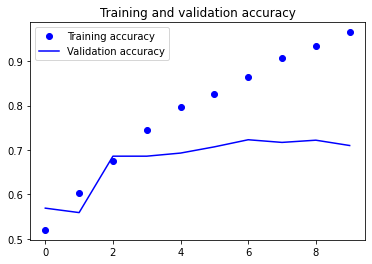

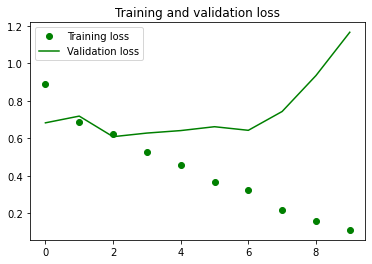

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

20회 에포크에서 훈련 정확도는 1.0에 근접한 반면, 테스트의 정확도는 100회 훈련이 끝나도 0.7 수준에 머물고 있습니다.

이러한 현상을 **과적합(Overfitting)**이라고 합니다.

### 테스트 이미지 분류하기

아래의 테스트 이미지를 사용해서 훈련된 모델이 개와 고양이 이미지를 분류할 수 있는지 확인해보겠습니다.

https://webnautes.tistory.com/1529

https://rfriend.tistory.com/431

Saving classifying_the_cats_and_dogs_09.png to classifying_the_cats_and_dogs_09 (4).png
[[[ 71.  79.  82.]
  [ 72.  80.  83.]
  [ 73.  81.  84.]
  ...
  [101. 108. 114.]
  [ 98. 107. 112.]
  [ 97. 106. 111.]]

 [[ 72.  80.  83.]
  [ 72.  80.  83.]
  [ 73.  81.  84.]
  ...
  [101. 108. 114.]
  [ 97. 106. 111.]
  [ 97. 106. 111.]]

 [[ 73.  81.  84.]
  [ 74.  82.  85.]
  [ 74.  82.  85.]
  ...
  [ 99. 106. 112.]
  [ 95. 104. 109.]
  [ 94. 103. 108.]]

 ...

 [[200. 203. 208.]
  [201. 204. 209.]
  [202. 205. 210.]
  ...
  [210. 213. 218.]
  [208. 211. 216.]
  [208. 211. 216.]]

 [[200. 203. 208.]
  [201. 204. 209.]
  [202. 205. 210.]
  ...
  [209. 212. 217.]
  [208. 211. 216.]
  [208. 211. 216.]]

 [[199. 204. 207.]
  [200. 205. 208.]
  [201. 206. 209.]
  ...
  [207. 212. 215.]
  [206. 211. 214.]
  [206. 211. 214.]]]
[[[[ 71.  79.  82.]
   [ 72.  80.  83.]
   [ 73.  81.  84.]
   ...
   [101. 108. 114.]
   [ 98. 107. 112.]
   [ 97. 106. 111.]]

  [[ 72.  80.  83.]
   [ 72.  80.  83.]
   [ 

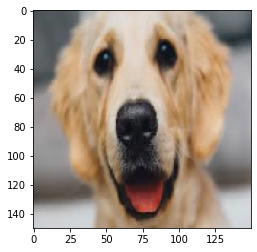

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path='/content/'+fn
  img = image.load_img(path, target_size=(150,150)) # 이미지 파일을 불러오고

  x = image.img_to_array(img) # 딥러닝 모델과 같이 사용하기 위해 PIL 형식의 이미지를 NumPy 배열로 변환하기 위한 함수
  print(x)
  x = np.expand_dims(x, axis=0) # 차원 추가 (2차원 -> 3차원)
  print(x)
  images = np.vstack([x])
  print(images)

  plt.imshow(img)

  classes = model.predict(images, batch_size=10)

  print(classes[0])  
  if classes[0]>0:
    print(fn + 'is a dog')
  else:
    print(fn + 'is a cat')

# 그냥 이런게 있구나

https://dacon.io/forum/406167

이미지 프로세싱 -> 블러, 노이즈 감소, 엣지, 디텍션

데이터의 양이 방대하지 않은경우 탐욕적 기법 (Greedy Aproach)